<h1 style="text-align:center; color:green; font-size:48px;">
Step 2: Heating Network Expansion
</h1>

#### Install libraries (if you did not do it before on the terminal)

In [1]:
# !pip install numpy==2.0.2 pandas==2.3.1
# !pip install matplotlib
# !pip install git+https://github.com/oemof/dhnx.git@dev
# !pip install osmnx==1.9.4 oemof.solph==0.5.6

# Import libraries

In [2]:
import matplotlib.pyplot as plt
import dhnx
import pandas as pd
import oemof.solph
from pyomo.environ import SolverFactory


## 2.1 Create network and plot

In [3]:
# Initialize thermal network
network = dhnx.network.ThermalNetwork()

# Load town parameter
network = network.from_csv_folder(r"STEP_2/twn_data")
    
# Load investment parameter
invest_opt = dhnx.input_output.load_invest_options(r"STEP_2/invest_data")

No sequences found to create timeindex from


In [4]:
print(network)

dhnx.network.ThermalNetwork object with these components
 * 5 producers
 * 10 consumers
 * 8 forks
 * 28 pipes



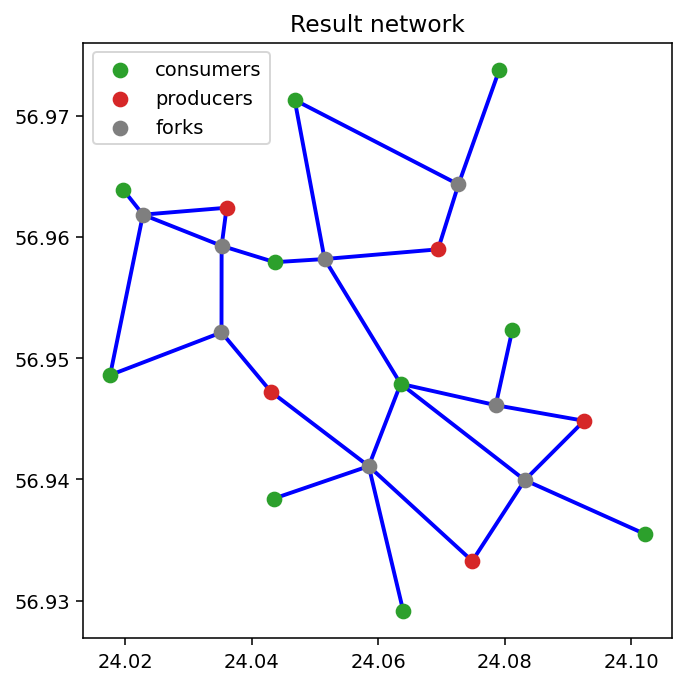

In [5]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_1 = dhnx.plotting.StaticMap(network)
static_map_1.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
# plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
# plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

## 2.2 Investment optimization of the network

In [6]:
# Optimize the investment data
# Check available solvers and use an appropriate one
available_solvers = ['gurobi', 'cbc', 'glpk']
solver_to_use = None

for solver in available_solvers:
	if SolverFactory(solver).available():
		solver_to_use = solver
		print(f"Using solver: {solver}")
		break

if solver_to_use is None:
	raise Exception("No suitable solver found. Please install glpk or cbc.")

try:
	network.optimize_investment(invest_options=invest_opt, solver=solver_to_use)
except ValueError as e:
	print("Optimization failed with ValueError:", e)
	# Reset any existing investment/capacity columns on pipes that may cause conflicts
	if 'pipes' in network.components and hasattr(network.components['pipes'], 'columns'):
		pipes_df = network.components['pipes']
		if 'investment' in pipes_df.columns:
			pipes_df['investment'] = 0
		if 'capacity' in pipes_df.columns:
			pipes_df['capacity'] = 0
		network.components['pipes'] = pipes_df

	# Try again once after resetting
	try:
		network.optimize_investment(invest_options=invest_opt, solver=solver_to_use)
	except Exception as e2:
		# surface the original and the retry failure
		print("Retry failed:", e2)
		raise


Using solver: gurobi


c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\solph\flows\_flow.py:163: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_value. Both options cannot be set at the same time.
  warn(msg, FutureWarning)
c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\network\network\nodes.py:250: FutureWarning: Usage of oemof.network.Component is deprecated. Use oemof.network.Node instead.
  warnings.warn(


Read LP format model from file C:\Users\irfan\AppData\Local\Temp\tmpviozwwn1.pyomo.lp
Reading time = 0.04 seconds
x1: 1373 rows, 1205 columns, 3155 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1373 rows, 1205 columns and 3155 nonzeros
Model fingerprint: 0x45fcce78
Variable types: 1055 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+04]
  Objective range  [4e+00, 4e+07]
  Bounds range     [1e+00, 2e+04]
  RHS range        [1e+02, 3e+03]
Presolve removed 1105 rows and 805 columns
Presolve time: 0.01s
Presolved: 268 rows, 400 columns, 1020 nonzeros
Variable types: 250 continuous, 150 integer (150 binary)
Found heuristic solution: objective 4.301386e+08
Found heuristic solution: objective 4.236187e+08
Found heuristic so

INFO:root:Optimization successful...


## 2.3 Results postprocessing and Plotting 


In [7]:
# ####### Postprocessing and Plotting ###########
results_edges = network.results.optimization['components']['pipes']
print(results_edges[['from_node', 'to_node', 'hp_type', 'capacity',
                     'direction', 'costs', 'losses']])

results_edges.to_csv("STEP_2/Outputs/Optimum_network_base.csv", index=True)

print('Objective value: ', network.results.optimization['oemof_meta']['objective'])

# assign new ThermalNetwork with invested pipes
twn_results = network
twn_results.components['pipes'] = results_edges[results_edges['capacity'] > 0.001]



      from_node      to_node hp_type     capacity  direction         costs  \
id                                                                           
0       forks-3  consumers-0    DN80   908.669134          1  1.966992e+06   
1       forks-3  producers-1    None     0.000000          0  0.000000e+00   
2   producers-1      forks-0    DN80  1236.617327          1  2.522844e+06   
3       forks-3      forks-0    DN80   914.344349         -1  3.506887e+06   
4       forks-3  consumers-1    None     0.000000          0  0.000000e+00   
5       forks-6  consumers-5   DN125  2636.713949          1  4.628416e+06   
6       forks-0      forks-2    None     0.000000          0  0.000000e+00   
7       forks-0  consumers-2    DN40   317.904684          1  2.386142e+06   
8       forks-1  consumers-2    None     0.000000          0  0.000000e+00   
9       forks-1  consumers-6    None     0.000000          0  0.000000e+00   
10      forks-1  producers-2    None     0.000000          0  0.

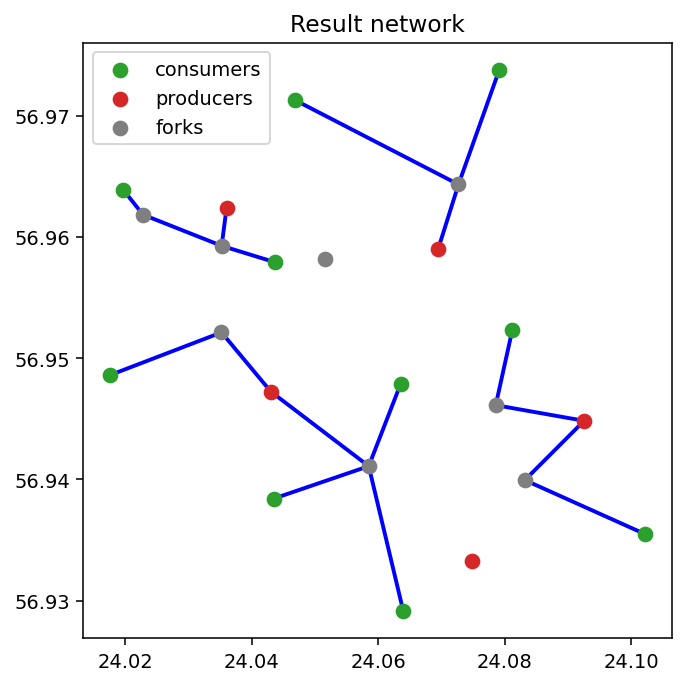

In [8]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_2 = dhnx.plotting.StaticMap(twn_results)
static_map_2.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
# plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
# plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

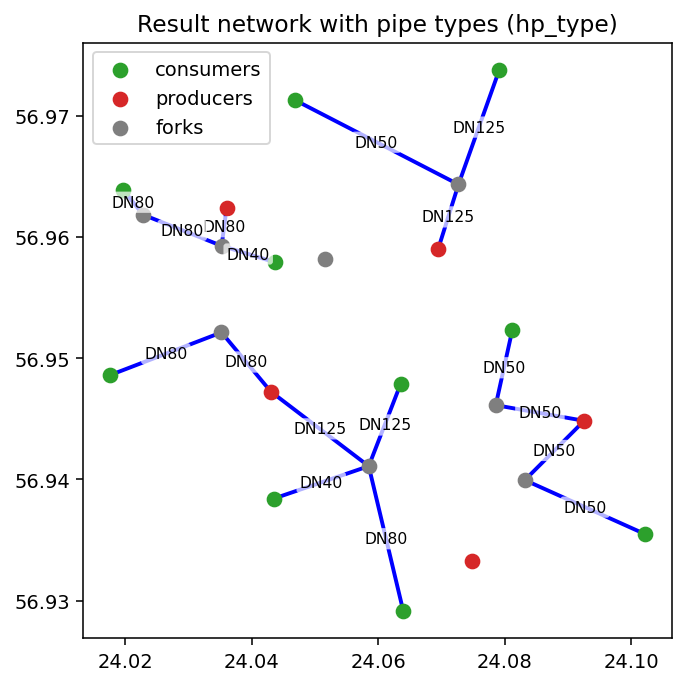

In [9]:

# ---------- Load selected pipes from STEP 2 ----------
results_edges = pd.read_csv("STEP_2/outputs/Optimum_network_base.csv", index_col=0)

# keep only invested pipes
pipes_selected = results_edges[results_edges["capacity"] > 0.001].copy()

# ---------- Update network with invested pipes ----------
# assumes 'network' already exists from previous steps
twn_results = network
twn_results.components['pipes'] = pipes_selected

# helper to get node coordinates from names like "consumers-0", "producers-1", "forks-2"
def get_node_coords(node_name):
    comp_type, idx = node_name.split("-", 1)          # e.g. "consumers", "0"
    df = getattr(network.components, comp_type)       # e.g. network.components.consumers

    # try numeric index first, then string index fallback
    try:
        idx_conv = int(idx)
        lon = df.loc[idx_conv, "lon"]
        lat = df.loc[idx_conv, "lat"]
    except (ValueError, KeyError):
        lon = df.loc[idx, "lon"]
        lat = df.loc[idx, "lat"]
    return lon, lat

# ---------- Plot topology with pipe-type labels ----------
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 140

static_map_2 = dhnx.plotting.StaticMap(twn_results)
# edges: keep default (blue, as in your picture)
static_map_2.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network with pipe types (hp_type)')

# nodes: match your picture colors
plt.scatter(
    network.components.consumers['lon'],
    network.components.consumers['lat'],
    color='tab:green',       # consumers = green
    label='consumers',
    zorder=2.5,
    s=50
)
plt.scatter(
    network.components.producers['lon'],
    network.components.producers['lat'],
    color='tab:red',         # producers = red
    label='producers',
    zorder=2.5,
    s=50
)
plt.scatter(
    network.components.forks['lon'],
    network.components.forks['lat'],
    color='tab:grey',        # forks = grey
    label='forks',
    zorder=2.5,
    s=50
)

# label each invested pipe with its hp_type at the midpoint
for pipe_id, row in pipes_selected.iterrows():
    hp_type = row.get("hp_type", "")
    if isinstance(hp_type, str) and hp_type.strip():
        lon_from, lat_from = get_node_coords(row["from_node"])
        lon_to,   lat_to   = get_node_coords(row["to_node"])

        x_mid = 0.5 * (lon_from + lon_to)
        y_mid = 0.5 * (lat_from + lat_to)

        ax.text(
            x_mid,
            y_mid,
            hp_type,
            fontsize=8,
            ha="center",
            va="center",
            clip_on=True,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
            zorder=3,
        )

plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# ========= USER INPUT =========
# Set this to the row index in producers.csv that you want to EXCLUDE
# (e.g. 0 to exclude producer-0, 1 to exclude producer-1).
# Leave it as '' (empty string) to include all producers.
exclude_row = '4'   # <-- change to e.g. 0, 1, 2, ... or keep '' for all
# ==============================

# --- Load pipe losses ---
pipes = pd.read_csv("STEP_2/outputs/Optimum_network_base.csv")

# Optionally exclude pipes connected to a specific producer
if exclude_row != '':
    producer_label = f"producers-{exclude_row}"
    # Filter out pipes where from_node or to_node is the excluded producer
    pipes_filtered = pipes[(pipes["from_node"] != producer_label) & 
                           (pipes["to_node"] != producer_label)]
    print(f"Excluding pipes connected to {producer_label}")
else:
    pipes_filtered = pipes

losses = pd.to_numeric(pipes_filtered["losses"], errors="coerce")
total_losses = losses.sum()

# --- Load consumer demands ---
consumers = pd.read_csv("STEP_2/twn_data/consumers.csv")

if "P_heat_max" not in consumers.columns:
    raise ValueError("Column 'P_heat_max' not found in consumers.csv")

demand_series = pd.to_numeric(consumers["P_heat_max"], errors="coerce")
total_demand = demand_series.sum()

# --- Compute percentage ---
if total_demand == 0:
    loss_share_pct = float('nan')
else:
    loss_share_pct = (total_losses / total_demand) * 100

print(f"Total losses (sum of 'losses' in pipes): {total_losses:.3f}")
print(f"Total demand (sum of 'P_heat_max'): {total_demand:.3f}")
if exclude_row != '':
    print(f"(Pipes connected to producers-{exclude_row} have been excluded from losses.)")
print(f"Losses ratio as percentage of demand: {loss_share_pct:.2f}%")


Excluding pipes connected to producers-4
Total losses (sum of 'losses' in pipes): 184.229
Total demand (sum of 'P_heat_max'): 11250.770
(Pipes connected to producers-4 have been excluded from losses.)
Losses ratio as percentage of demand: 1.64%
